In [1]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf

# from transformers import BertTokenizerFast
from sklearn.model_selection import train_test_split

In [2]:
def get_ds():
    url = "https://datasets-server.huggingface.co/parquet?dataset=aadityaubhat%2FGPT-wiki-intro"
    response = requests.get(url)
    if response.status_code !=200:
        return f"error during dataset request: {response.status_code}"
    
    url_parquet = [files['url'] for files in response.json()['parquet_files']]
    
    
    df = [pd.read_parquet(url_) for url_ in url_parquet]
    
    return pd.concat(df)

In [3]:
path_data = os.path.join(os.path.dirname(os.path.abspath(os.path.curdir)),'raw_data')
if 'data.csv' in os.listdir(path_data):
    print('loading local')
    df = pd.read_csv(path_data+'/data.csv',index_col='id')
else:
    df = get_ds()
    df.set_index('id',inplace=True)
    df['random']=np.random.random(len(df))
    
    # reorganize ds and randomize samples wiki/generated
    df.loc[df['random']<.5,'text']=df['generated_intro']
    df.loc[df['random']<.5,'label']='generated'
    df.loc[df['random']>=.5,'text']=df['wiki_intro']
    df.loc[df['random']>=.5,'label']='wiki'
    df.to_csv('../raw_data/data.csv')
    
df.head()

loading local


,url,title,wiki_intro,generated_intro,title_len,wiki_intro_len,generated_intro_len,prompt,generated_text,prompt_tokens,generated_text_tokens,random,text,label
id,,,,,,,,,,,,,,
63064638,https://en.wikipedia.org/wiki/Sexhow%20railway...,Sexhow railway station,Sexhow railway station was a railway station b...,Sexhow railway station was a railway station l...,3,174,78,200 word wikipedia style introduction on 'Sexh...,"located in the town of Sexhow, on the Cumbria...",25,88,0.170068,Sexhow railway station was a railway station l...,generated
279621,https://en.wikipedia.org/wiki/Eti%C3%A4inen,Etiäinen,"In Finnish folklore, all places and things, an...","In Finnish folklore, all places and things, an...",1,187,80,200 word wikipedia style introduction on 'Etiä...,"animate or inanimate, have a spirit or ""etiäi...",26,101,0.839452,"In Finnish folklore, all places and things, an...",wiki
287229,https://en.wikipedia.org/wiki/Inverse%20functi...,Inverse function theorem,"In mathematics, specifically differential calc...","In mathematics, specifically differential calc...",3,170,59,200 word wikipedia style introduction on 'Inve...,function theorem states that for every real-v...,26,65,0.532203,"In mathematics, specifically differential calc...",wiki
26712375,https://en.wikipedia.org/wiki/Stepping%20on%20...,Stepping on Roses,is a Japanese shōjo manga series written and i...,is a Japanese shōjo manga series written and i...,3,335,121,200 word wikipedia style introduction on 'Step...,and illustrated by Maki Fujii. The series fol...,26,150,0.715507,is a Japanese shōjo manga series written and i...,wiki
38894426,https://en.wikipedia.org/wiki/Rob%20Bradley,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...","Robert Milner ""Rob"" Bradley, Jr. (born August ...",2,170,136,200 word wikipedia style introduction on 'Rob ...,"29, 1973) is an American former professional ...",28,162,0.395063,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",generated


In [4]:
# X_train,X_test,y_train,y_test = train_test_split(df['text'],df['label'],test_size=.2)
# y_train = np.where(y_train=='generated',1,0)
# y_test = np.where(y_test=='generated',1,0)

In [5]:
df['# sentences'] = df['text'].apply(lambda x : len(x.split('.')))

In [6]:
def word_per_sentence(text):
    sentences = text.split('.')
    lengths = []
    for s in sentences : 
        lengths.append(len(s.split()))
    return [np.mean(np.array(lengths)),np.std(np.array(lengths))]

In [7]:
df_e = pd.concat([df,df['text'].apply(word_per_sentence).apply(pd.Series).rename({0:'mean_w_p_s',1:'var_w_p_s'},axis=1)],axis=1)

In [21]:
import matplotlib.pyplot as plt

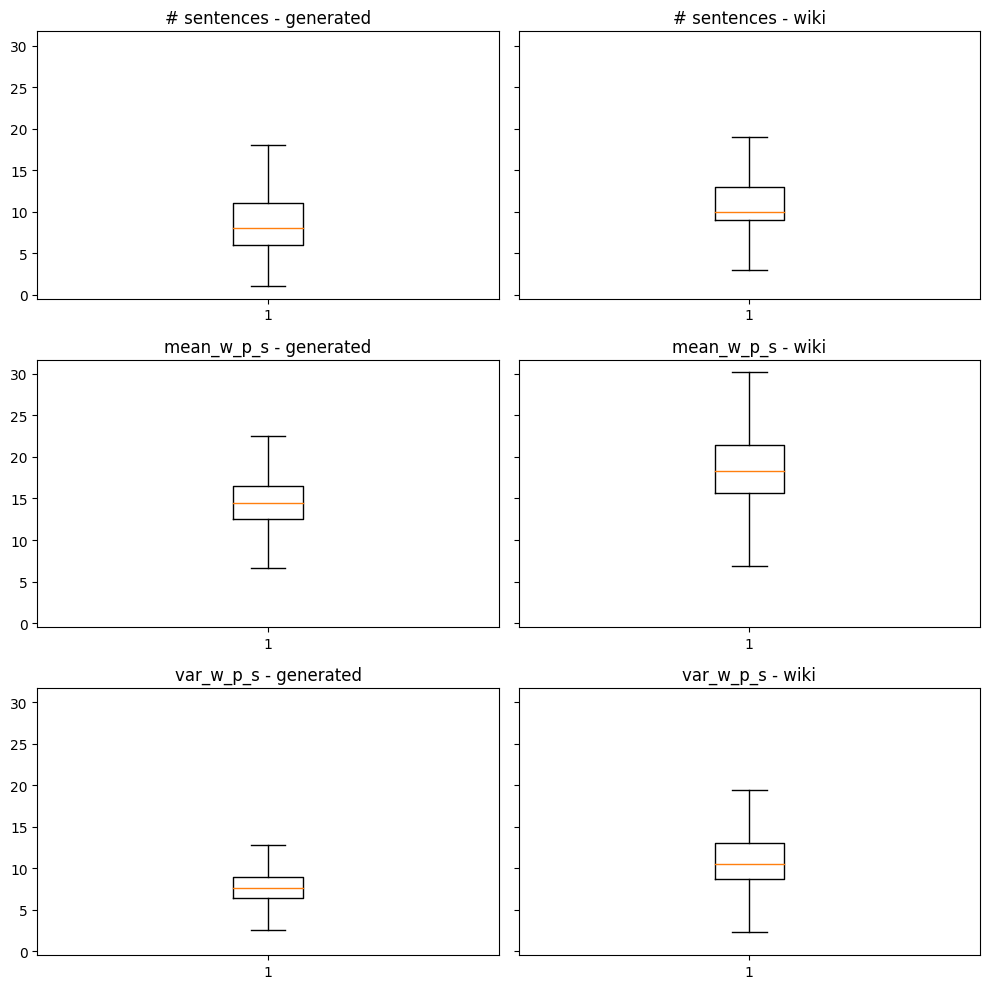

In [38]:
fig,axs = plt.subplots(3,2,figsize=(10,10),sharey=True,tight_layout=True)
axs[0,0].boxplot(df_e[df_e['label']=='generated']['# sentences'],showfliers=False)
axs[0,1].boxplot(df_e[df_e['label']=='wiki']['# sentences'],showfliers=False)
axs[0,0].set_title('# sentences - generated')
axs[0,1].set_title('# sentences - wiki');
axs[1,0].boxplot(df_e[df_e['label']=='generated']['mean_w_p_s'],showfliers=False)
axs[1,1].boxplot(df_e[df_e['label']=='wiki']['mean_w_p_s'],showfliers=False)
axs[1,0].set_title('mean_w_p_s - generated')
axs[1,1].set_title('mean_w_p_s - wiki');
axs[2,0].boxplot(df_e[df_e['label']=='generated']['var_w_p_s'],showfliers=False)
axs[2,1].boxplot(df_e[df_e['label']=='wiki']['var_w_p_s'],showfliers=False)
axs[2,0].set_title('var_w_p_s - generated')
axs[2,1].set_title('var_w_p_s - wiki');

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
model = RandomForestClassifier(n_estimators=100,max_depth=5,min_samples_leaf=10)

In [60]:
X_train,X_test,y_train,y_test = train_test_split(df_e[['# sentences','mean_w_p_s','var_w_p_s']],df_e['label'],test_size=.2)
y_train = np.where(y_train=='generated',1,0)
y_test = np.where(y_test=='generated',1,0)

In [61]:
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=10)

In [65]:
model.score(X_test,y_test)

0.8415666666666667

In [68]:
np.random.randint(12000)

2976

In [71]:
np.random.randint(1,10,2)

array([9, 5])

In [73]:
for i in np.random.randint(0,len(df_e),10):
    print(df_e.reset_index().loc[i,'label'])
    print('----------------')
    print(df_e.reset_index().loc[i,'text'])
    print('################')

wiki
----------------
Alfonso D'Artega (June 5, 1907 – January 20, 1998), often known simply as D'Artega, was a songwriter, conductor, arranger and actor. His song "In the Blue of Evening", co-written with Tom Adair, was a number one hit for the Tommy Dorsey Orchestra in 1943. D'Artega was born in Silao, Guanajuato, Mexico. His family emigrated to the U.S. in 1918. D'Artega studied music and composition at Strassberger's Conservatory in St. Louis, Missouri with Boris Levenson, who was a pupil of Nikolai Rimsky-Korsakov. He became a well-known conductor on stage and on air, and in 1946 initiated the Carnegie Hall "Pops" concerts with members of the New York Philharmonic. In 1947 he played the role of Tchaikovsky in the film Carnegie Hall, conducting the film score as well. He was guest conductor with, among others, the Buffalo Symphony Orchestra, the Miami Symphony Orchestra, the Saint Louis Symphony Orchestra and the NBC Symphony of the Air.
################
generated
----------------
